In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sphere class
class Sphere:
    def __init__(self, position, velocity, stokes_no, vel_others, drag_acc):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.acceleration = np.zeros(3, dtype=float)
        self.stokes_no = stokes_no
        self.vel_others = np.zeros(3, dtype=float)
        self.drag_acc = np.array(drag_acc, dtype=float)
        self.position_history = [self.position.copy()]
        self.velocity_history = [self.velocity.copy()]
        self.acceleration_history = [self.acceleration.copy()]
        self.drag_acc_history = [self.drag_acc.copy()]

    def update_vel_others(self, new_vel_others):
        self.vel_others = new_vel_others

    def update(self, new_position, new_velocity, new_acceleration, new_stokes_no, new_vel_others, new_drag_acc):
        self.position = new_position
        self.velocity = new_velocity
        self.acceleration = new_acceleration
        self.stokes_no = new_stokes_no
        self.vel_others = new_vel_others
        self.drag_acc = new_drag_acc
        self.position_history.append(self.position.copy())
        self.velocity_history.append(self.velocity.copy())
        self.acceleration_history.append(self.acceleration.copy())
        self.drag_acc_history.append(self.drag_acc.copy())

# Parameters
t_flow = 100
omega = 1e-4
t_response = 10
ST = t_response / t_flow  # Stokes number wrt flow
ST_ROT = t_response * omega  # Stokes number wrt rotation
g = 6.0
v_terminal = g * t_response
FR_PART = 1/20.0
mu = 1/(np.pi*6*t_response) # viscosity
N = 10  # Number of particles
A = 5  # Amplitude of the sinusoid
d = 20  # Interparticle distance
k = 1  # Wave number
dt = 0.1  # Time step for the simulation
total_time = 5  # Total simulation time

# Initial positions and velocities of spheres with sinusoidal perturbation
spheres = []
for i in range(N):
    x_position = 20 + i * d
    y_position = 200 + A * np.sin(k * 8 * (x_position - 20) / (N * d))
    initial_position = np.array([x_position, y_position, 0])/d #Non-dimensionalisation
    initial_velocity = np.array([0, 1.5, 0])/v_terminal #Non-dimensionalisation
    initial_drag_acc = -(1 / ST) * (initial_velocity) 

    spheres.append(Sphere(position=initial_position, velocity=initial_velocity, stokes_no=ST, vel_others=np.zeros(3), drag_acc=initial_drag_acc))


# Gravity force on particles
acc_g = np.array([[0, -g, 0] for _ in range(N)], dtype=float)

# Function to compute the G matrix
def compute_G_matrix(positions, mu):
    N = len(positions)
    G_matrix = np.zeros((3*N, 3*N))  # Initialize the G matrix
    for i in range(N):
        for j in range(N):
            if i != j:
                r_diff = positions[i] - positions[j]
                r_norm = np.linalg.norm(r_diff)
                I = np.eye(3)
                if r_norm == 0:
                    G = np.zeros((3, 3))  # Avoid division by zero at the singularity
                else:
                    G = (1 / (8 * np.pi * mu)) * (I / r_norm + np.outer(r_diff, r_diff) / r_norm ** 3)
                G_matrix[3*i:3*i+3, 3*j:3*j+3] = G

    return G_matrix


# Function to solve for vel_others
def solve_for_vel_others(spheres, G_matrix):
    N = len(spheres)
    velocities = np.array([sphere.velocity for sphere in spheres]).flatten()
    vel_others = np.zeros_like(velocities)

    # Construct the right-hand side of the equation
    rhs = np.zeros(3 * N)
    for i in range(N):
        for j in range(N):
            if i != j:
                G_ij = G_matrix[3*i:3*i+3, 3*j:3*j+3]
                rhs[3*i:3*i+3] += G_ij @ (velocities[3*j:3*j+3] - vel_others[3*j:3*j+3])/ST
                #print(rhs)

    # Solve for vel_others
    A = np.eye(3 * N) - G_matrix
    vel_others = np.linalg.solve(A, rhs)

    # Update spheres with new vel_others
    vel_others = vel_others.reshape((N, 3))
    for i, sphere in enumerate(spheres):
        sphere.update_vel_others(vel_others[i])

# Function to solve the ODE
def velocity_ode(t, v, vel_others, ST, ST_ROT, g, FR_PART):
    Zhat = np.array([0, 0, 1])
    yhat = np.array([0, 1, 0])
    dv_dt = (vel_others - v) / ST -2* np.cross(ST_ROT * Zhat, v) + (1 /ST) * yhat
    return dv_dt



Stokes Number 0.1
Stokes Number Rotational 0.001


In [3]:
print("Stokes", ST)
print("Stokes_rot", ST_ROT)
print("vel",spheres[1].velocity)
print("u infini",spheres[1].vel_others)
print("drag",(spheres[1].vel_others - spheres[1].velocity)/ST)
print("mu",mu)
print("vterminal", g*t_response)
print("g term" ,1/ST)

# Function to integrate velocities to find positions and update spheres
def integrate_and_update_spheres(spheres, dt):
    for sphere in spheres:
        # Solve the ODE to get the new velocity
        sol = solve_ivp(velocity_ode, [0, dt], sphere.velocity, args=(sphere.vel_others, ST, ST_ROT, g, FR_PART), t_eval=[dt])
        new_velocity = sol.y[:, -1]

        # Update position
        new_position = sphere.position + new_velocity * dt

        # Update acceleration
        new_acceleration = (new_velocity - sphere.velocity) / dt

        # Update sphere
        sphere.update(new_position, new_velocity, new_acceleration, sphere.stokes_no, sphere.vel_others, sphere.drag_acc)

Stokes 0.1
Stokes_rot 0.001
vel [0.    0.025 0.   ]
u infini [0. 0. 0.]
drag [ 0.   -0.25  0.  ]
mu 0.005305164769729845
vterminal 60.0
g term 10.0


Time step 1/1000
Particle 1 velocity: [0.    0.025 0.   ]
Particle 2 velocity: [0.    0.025 0.   ]
Particle 3 velocity: [0.    0.025 0.   ]
Particle 4 velocity: [0.    0.025 0.   ]
Particle 5 velocity: [0.    0.025 0.   ]
Particle 6 velocity: [0.    0.025 0.   ]
Particle 7 velocity: [0.    0.025 0.   ]
Particle 8 velocity: [0.    0.025 0.   ]
Particle 9 velocity: [0.    0.025 0.   ]
Particle 10 velocity: [0.    0.025 0.   ]
Time step 2/1000
Particle 1 velocity: [-0.00156502  0.47613952  0.        ]
Particle 2 velocity: [2.61165709e-05 4.70592181e-01 0.00000000e+00]
Particle 3 velocity: [0.00192692 0.47241276 0.        ]
Particle 4 velocity: [0.00229308 0.4802582  0.        ]
Particle 5 velocity: [1.14908069e-04 4.86914361e-01 0.00000000e+00]
Particle 6 velocity: [-0.00314032  0.48675907  0.        ]
Particle 7 velocity: [-0.00389082  0.48018418  0.        ]
Particle 8 velocity: [-0.00060282  0.47257414  0.        ]
Particle 9 velocity: [0.00390792 0.47037275 0.        ]
Particle 10 vel

KeyboardInterrupt: 

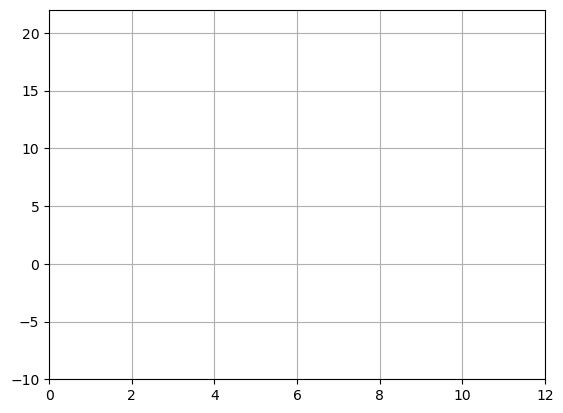

In [3]:
%%time

# Set up the plot
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xlim(0, 12)
ax.set_ylim(0, 22)


total_time =  100
# Simulation loop
time_steps = int(total_time / dt)
for step in range(time_steps):
    print(f"Time step {step+1}/{time_steps}")
    for i, sphere in enumerate(spheres):
      #print(f"Particle {i+1} position: {sphere.position}")
      print(f"Particle {i+1} velocity: {sphere.velocity}")

    # Step 1: Solve linear system of equations to get vel_others of each sphere
    positions = np.array([sphere.position for sphere in spheres])
    G_matrix = compute_G_matrix(positions, mu)
    solve_for_vel_others(spheres, G_matrix)


    # Step 2 and 3: Solve the ODE and integrate velocities to find positions
    integrate_and_update_spheres(spheres, dt)

    #Make plots of position of sphere in XY plane
    # Update the plot
    ax.clear()
    ax.set_xlim(0, 12)
    ax.set_ylim(-10, 22)
    ax.grid(True)
    ax.scatter([sphere.position[0] for sphere in spheres], [sphere.position[1] for sphere in spheres], color='r')
    #plt.pause(0.1)
    plt.savefig(f'plots/plot_{step:04d}.png')  # Save the plot

# Print final positions and velocities
for i, sphere in enumerate(spheres):
    print(f"Particle {i+1} final position: {sphere.position}")
    print(f"Particle {i+1} final velocity: {sphere.velocity}")
